# Libraries

In [27]:
import plotly.offline as pox
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

# Import Dataset

In [42]:
df = pd.read_csv('axp_data.csv')
#df = pd.read_csv('amzn_data.csv')
# Filter and remove rows where 'volume' is 0
d = df[df['volume'] == 0]
df = df.drop(d.index, axis=0)

# Convert 'time' to datetime format and extract only the date part
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.date

# Set the 'time' column as the index
df = df.set_index('time')

# Sort the DataFrame by date
df = df.sort_index(ascending=True)

# Create a copy of the modified DataFrame
next = df.copy()

# Display the tail of the new DataFrame and print "done"
next.tail()

,open,high,low,close,volume
time,,,,,
2024-10-30,271.000000,275.070007,270.269989,274.079987,2152900
2024-10-31,273.700012,274.079987,268.640015,270.079987,2315400
2024-11-01,272.299988,274.750000,270.950012,272.690002,2508300
2024-11-04,272.329987,272.820007,269.709991,270.190002,1944000
2024-11-05,271.720001,276.179993,271.190002,275.940002,1856800


# Create Features

In [43]:
# Calculate future returns and signals
df['future_returns'] = df['close'].pct_change().shift(-1)
signal = []
for i in range(len(df)):
    if df['future_returns'].iloc[i] > 0:
        signal.append(1)
    elif df['future_returns'].iloc[i] < 0:
        signal.append(2)
    else:
        signal.append(3)

df['signal'] = signal

# Calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = calculate_rsi(df['close'], 14)

# Calculate ADX
def calculate_adx(df, period=50):
    high = df['high']
    low = df['low']
    close = df['close']

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = true_range.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
    minus_di = 100 * (minus_dm.abs().rolling(window=period).mean() / atr)

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    return adx

df['adx'] = calculate_adx(df, 50)

# Calculate NATR
def calculate_natr(df, period=50):
    tr1 = df['high'] - df['low']
    tr2 = abs(df['high'] - df['close'].shift(1))
    tr3 = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    natr = (atr / df['close']) * 100
    return natr

df['NATR'] = calculate_natr(df, 50)

# Calculate SMA
df['sma'] = df['close'].rolling(window=30).mean()

# Calculate correlation
df['corr'] = df['close'].rolling(window=int(6.5 * 4)).corr(df['sma'])

# Other features
df['Open-Close'] = (df['open'] - df['close']).shift(-1)
df['Close-High'] = (df['close'] - df['high']).shift(-1)
df['Close-Low'] = (df['close'] - df['low']).shift(-1)

# Drop NaN values
df.dropna(inplace=True)

# Define target and features
y = df[['signal']].copy()
X = df[['rsi', 'adx', 'corr', 'sma', 'NATR', 'volume', 'Open-Close', 'Close-Low', 'Close-High']].copy()

In [44]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns

    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))

MultiIndex([], )


In [45]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

rsi is stationary.
adx is stationary.
corr is stationary.
sma is not stationary. Dropping it.
NATR is stationary.
volume is stationary.
Open-Close is stationary.
Close-Low is stationary.
Close-High is stationary.


# Models

## Random Forest

In [46]:
split_percentage = 0.7
split = int(split_percentage*len(df))


# Train data set
X_train = X[:split]
y_train = y[:split]
X_test =  X[split:]
y_test =  y[split:]

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
model = RandomForestClassifier(n_estimators=100,random_state=30)
model.fit(X_train, y_train['signal'])
y_pred = model.predict(X_test)
Accuracy =accuracy_score(y_test, y_pred)
print(Accuracy)

0.8125948406676783


## Voting Classifier

In [47]:
split_percentage = 0.7
split = int(split_percentage*len(df))


# Train data set
X_train = X[:split]
y_train = y[:split]
X_test =  X[split:]
y_test =  y[split:]

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=43)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=43)

# Combine models using VotingClassifier
model2 = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=43)),
        ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=43))
    ],
    voting='soft',  # 'soft' for probabilities, 'hard' for majority voting
    weights=[10, 3]  # Assign higher weight to the better-performing model
)
model2.fit(X_train, y_train.values.ravel())  # Training the model

# Predictions and evaluation
y_pred2 = model2.predict(X_test)
Accuracy =accuracy_score(y_test, y_pred2)
print(Accuracy)

0.8156297420333839


## LightGBM

In [48]:
# Encode target variable if necessary
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Converts categories to integers

# Split data
split_percentage = 0.7
split = int(split_percentage * len(df))

X_train = X[:split]
y_train = y_encoded[:split]
X_test = X[split:]
y_test = y_encoded[split:]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Prepare LightGBM dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train, weight=[class_weights_dict[i] for i in y_train])

# Define parameters
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbosity': -1
}

# Train the model
num_round = 100
model3 = lgb.train(
    params,
    train_data,
    num_round,
    valid_sets=[train_data]
)

# Predict
y_pred_probs = model3.predict(X_test_scaled)
y_pred3 = np.argmax(y_pred_probs, axis=1)

# Decode labels
y_pred_decoded = le.inverse_transform(y_pred3)
y_test_decoded = le.inverse_transform(y_test)

# Accuracy
Accuracy = accuracy_score(y_test, y_pred3)
print(f"Model Accuracy: {Accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Class Weights: {0: 0.6420217209690894, 1: 0.6989540700318326, 2: 85.38888888888889}
Model Accuracy: 0.808


# Portfolio Simulations

In [49]:
def simulate_trading(y_pred, prices, initial_capital=10000, commission=0.001):
    """
    Simulates trading based on the model's predictions.

    Parameters:
        y_pred: array-like
            Model predictions for buy (1), sell (2), or hold (3).
        prices: array-like
            Corresponding close prices for the test set.
        initial_capital: float, default=10000
            Starting capital in USD.
        commission: float, default=0.001
            Commission fee per trade (e.g., 0.001 for 0.1% commission).

    Returns:
        portfolio_value: list
            Portfolio value over time.
        final_portfolio_value: float
            Final portfolio value.
        profit: float
            Total profit in USD.
        profit_percentage: float
            Total profit as a percentage of the initial capital.
    """
    cash = initial_capital
    shares = 0
    portfolio_value = [initial_capital]

    for i in range(len(prices)):
        signal = y_pred[i]
        price = prices[i]

        if signal == 1:  # Buy signal
            if cash >= price:  # Only buy if sufficient cash is available
                cash -= price * (1 + commission)
                shares += 1
        elif signal == 2:  # Sell signal
            if shares > 0:  # Only sell if shares are held
                cash += price * (1 - commission)
                shares -= 1

        # Calculate portfolio value
        portfolio_value.append(cash + shares * price)

    # Calculate profitability metrics
    final_portfolio_value = portfolio_value[-1]
    profit = final_portfolio_value - initial_capital
    profit_percentage = (profit / initial_capital) * 100

    return portfolio_value, final_portfolio_value, profit, profit_percentage


In [50]:
# Simulate for Random Forest
rf_portfolio, rf_final_value, rf_profit, rf_profit_percentage = simulate_trading(
    y_pred, df['close'].iloc[split:].values
)

# Simulate for VotingClassifier
voting_portfolio, voting_final_value, voting_profit, voting_profit_percentage = simulate_trading(
    y_pred2, df['close'].iloc[split:].values
)

# Simulate for LightGBM
lgb_portfolio, lgb_final_value, lgb_profit, lgb_profit_percentage = simulate_trading(
    y_pred3, df['close'].iloc[split:].values
)

# Compare Results
print(f"Random Forest: Profit ${rf_profit:.2f} ({rf_profit_percentage:.2f}%)")
print(f"VotingClassifier: Profit ${voting_profit:.2f} ({voting_profit_percentage:.2f}%)")
print(f"LightGBM: Profit ${lgb_profit:.2f} ({lgb_profit_percentage:.2f}%)")


Random Forest: Profit $10189.29 (101.89%)
VotingClassifier: Profit $9543.54 (95.44%)
LightGBM: Profit $12703.53 (127.04%)


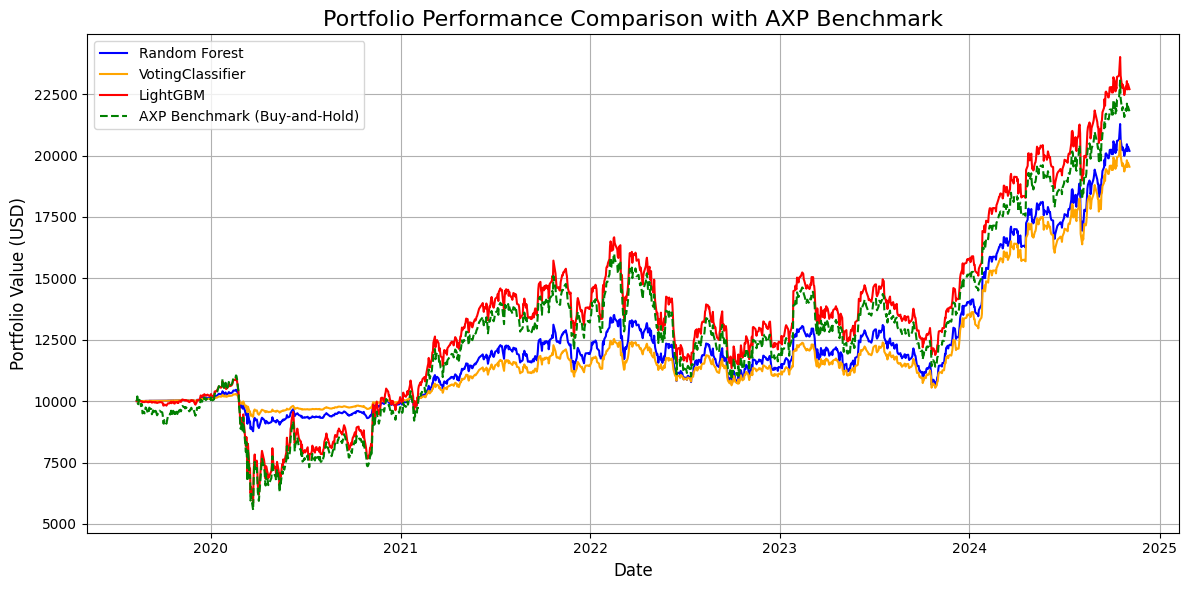

In [54]:
initial_capital=10000

# Simulate the benchmark (buy-and-hold strategy)
benchmark_shares = initial_capital / df['close'].iloc[split]  # Buy shares at the start of the test period
benchmark_portfolio = [
    benchmark_shares * df['close'].iloc[split + i] for i in range(len(X_test))
]

# Time indices for the test set
test_dates = df.index[split:split + len(X_test)]

# Plot all portfolios
plt.figure(figsize=(12, 6))
plt.plot(test_dates, rf_portfolio[1:], label='Random Forest', color='blue')
plt.plot(test_dates, voting_portfolio[1:], label='VotingClassifier', color='orange')
plt.plot(test_dates, lgb_portfolio[1:], label='LightGBM', color='red')
plt.plot(test_dates, benchmark_portfolio, label='AXP Benchmark (Buy-and-Hold)', color='green', linestyle='--')
plt.title('Portfolio Performance Comparison with AXP Benchmark', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Calculate maximum drawdown (%)
cumulative_max1 = np.maximum.accumulate(rf_portfolio[1:])  # Exclude the first value for alignment
drawdown1 = (rf_portfolio[1:] - cumulative_max1) / cumulative_max1 * 100
max_drawdown1 = drawdown1.min()

cumulative_max2 = np.maximum.accumulate(voting_portfolio[1:])  # Exclude the first value for alignment
drawdown2 = (voting_portfolio[1:] - cumulative_max2) / cumulative_max2 * 100
max_drawdown2 = drawdown2.min()  # Now correctly using drawdown2

cumulative_max3 = np.maximum.accumulate(lgb_portfolio[1:])  # Exclude the first value for alignment
drawdown3 = (lgb_portfolio[1:] - cumulative_max3) / cumulative_max3 * 100
max_drawdown3 = drawdown3.min()

print(f"Random Forest: Maximum Drawdown: {max_drawdown1:.2f}%")
print(f"VotingClassifier: Maximum Drawdown: {max_drawdown2:.2f}%")
print(f"LightGBM: Maximum Drawdown: {max_drawdown3:.2f}%")

Random Forest: Maximum Drawdown: -21.11%
VotingClassifier: Maximum Drawdown: -15.86%
LightGBM: Maximum Drawdown: -46.51%


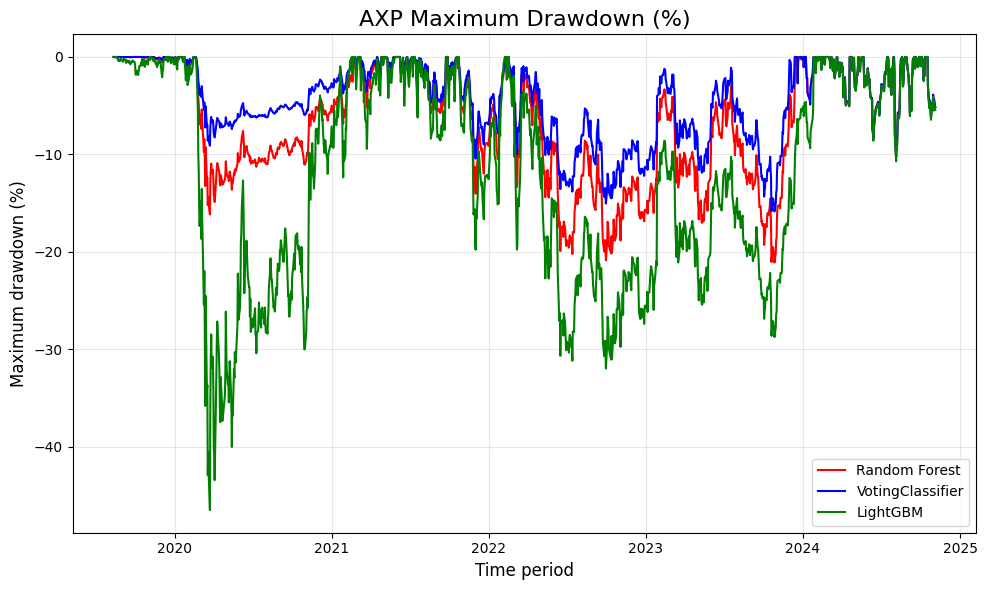

In [53]:
# Plotting the maximum drawdown graph
plt.figure(figsize=(10, 6))
plt.plot(test_dates, drawdown1, label='Random Forest', color='red')
plt.plot(test_dates, drawdown2, label='VotingClassifier', color='blue')
plt.plot(test_dates, drawdown3, label='LightGBM', color='green')
plt.title("AXP Maximum Drawdown (%)", fontsize=16)
plt.xlabel("Time period", fontsize=12)
plt.ylabel("Maximum drawdown (%)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()